In [1]:
%cd ..

c:\Users\YbII Diamondback\Documents\YbII


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Fitting Module
import lmfit
from lmfit.models import gaussian2d

# Image Processing Module
import imageio
import matplotlib.pyplot as plt

from src.functions.math import func as mathf
from src.functions.optics import func as optf
from src.constants import const

In [3]:
# p is the measured power per beam before any VP, w1 and w2 are the beam waist radii
# s0 = 2 * (I_0 * T + I_0 * T ** 3) / I_sat
def getS0(p, w1=0.329e-2, w2=0.866e-2):
    return 2 * p / np.pi / w1 / w2 * (0.915 + 0.915 ** 3) / const.Is_1s0_1p1

# probability of the atom being in the excited state (from Eva Casotti's thesis)
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
def rho(f, p):
    return getS0(p) / 2 / (1 + getS0(p) + (2 * (f - const.w0_1s0_1p1_32) / const.gamma_1s0_1p1) ** 2)

# sum up the pixel values in the region of interest
# x0, y0, wx, wy are the parameters of the Gaussian fit
# img_res is the background-subtracted image data
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
# d0 is the image distance from the MOT to the first lens
def getAtomNumber(x0, y0, wx, wy, img, t_exp, f, p, d0=320e-3):
    x0 = int(x0)
    y0 = int(y0)
    wx = int(wx)
    wy = int(wy)
    I_sum = np.sum(img[y0-wy:y0+wy, x0-wx:x0+wx])

    ppi = 2800 / 0.46 / 255 # photon per pixel per intensity
    eff = (0.0254/2) ** 2 / 4 / d0 ** 2 # collection efficiency of the imaging setup, assuming using 1 inch lens
    gamma_tot = I_sum * ppi / eff / t_exp # total photon emission rate
    gamma_atom = const.gamma_1s0_1p1 * rho(f, p) # photon emission rate of a single atom
    print(rho(f, p))
    return gamma_tot / gamma_atom

# get the number of imaged atoms
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# f is frequency of the cooling beam
# p is the measured power per beam before any VP
def getImagedAtomNumber(img, img_bg, t_exp, f, p):
    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res = np.abs(np.array(img, dtype=float) - np.array(img_bg, dtype=float))

    x_data = np.max(img_res, axis=0)
    y_data = np.max(img_res, axis=1)

    # also in /src/functions/math/func.py
    def GaussianWBaseline(x, center, sigma, amplitude, c_c):
        return amplitude * np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) + c_c

    model = lmfit.Model(GaussianWBaseline)

    # adjust the initial parameters if needed
    params_x = model.make_params(c_c=0, center=np.argmax(x_data), sigma=50, amplitude=np.max(x_data))
    params_y = model.make_params(c_c=0, center=np.argmax(y_data), sigma=50, amplitude=np.max(y_data))

    # Set constraints if needed
    params_x['sigma'].set(max=150)
    params_x['sigma'].set(min=50)
    params_y['sigma'].set(max=150)
    params_y['sigma'].set(min=50)
    params_x['amplitude'].set(min=15)
    params_y['amplitude'].set(min=0)
    params_x['center'].set(min=1500)
    params_x['center'].set(max=2200)
    params_x['c_c'].set(max=20)
    params_y['c_c'].set(max=20)

    result_x = model.fit(x_data, params_x, x=x_rg)
    result_y = model.fit(y_data, params_y, x=y_rg)

    x_fit = result_x.best_fit
    y_fit = result_y.best_fit

    x0 = result_x.best_values['center']
    y0 = result_y.best_values['center']

    wx = 2 * result_x.best_values['sigma']
    wy = 2 * result_y.best_values['sigma']

    return img_res, x0, y0, wx, wy, x_data, x_fit, y_data, y_fit, getAtomNumber(x0, y0, wx, wy, img_res, t_exp, f, p)

# plot the image data along with the Gaussian fit and the atom number
# img is the MOT image data, img_bg is the background image data
# t_exp is the exposure time of the camera
# df is the detuning from the Yb171 1S0 -> 1P1 transition in angular frequency units
# p is the measured power per beam before any VP
def plotMOTNumber(img, img_bg, t_exp, df, p):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    x_rg = np.arange(0, img.shape[1])
    y_rg = np.arange(0, img.shape[0])

    img_res, x0, y0, wx, wy, x_data, x_fit, y_data, y_fit, atom_num = getImagedAtomNumber(img, img_bg, t_exp, df, p)

    axs[0].imshow(img_res, cmap='gray', vmin=0, vmax=255)

    axs[0].set_xlim([0, img.shape[1]])
    axs[0].set_ylim([0, img.shape[0]])
    axs[0].set_xlabel('Pixel')
    axs[0].set_ylabel('Pixel')

    axs[0].hlines(y0-wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].hlines(y0+wy, x0-wx, x0+wx, color='b', linestyles='dashed')
    axs[0].vlines(x0-wx, y0-wy, y0+wy, color='r', linestyles='dashed')
    axs[0].vlines(x0+wx, y0-wy, y0+wy, color='r', linestyles='dashed')

    axs[1].scatter(x_rg, x_data)
    axs[1].plot(x_rg, x_fit, 'r', label='x Fit')
    axs[1].scatter(y_rg, y_data)
    axs[1].plot(y_rg, y_fit, 'b', label='y Fit')
    axs[1].vlines(x0-wx, 0, 100, color='r', linestyles='dashed', label='x bounds')
    axs[1].vlines(x0+wx, 0, 100, color='r', linestyles='dashed')
    axs[1].vlines(y0-wy, 0, 100, color='b', linestyles='dashed', label='y bounds')
    axs[1].vlines(y0+wy, 0, 100, color='b', linestyles='dashed')
    
    axs[1].set_xlabel('Pixel')
    axs[1].set_ylabel('Intensity')
    axs[1].legend()

    fig.suptitle('2D MOT #Atom ~ ' + str(int(round(atom_num, -4))))


C:\Users\YbII Diamondback\AppData\Local\Temp\ipykernel_1516\3158040206.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plotMOTNumber(imageio.imread('data/sample_image/sample_2DMOT/signal.bmp'), imageio.imread('data/sample_image/sample_2DMOT/background.bmp'), 17150e-6, 2 * np.pi * 751.5270397e12, 80e-3)


0.10046576965675656


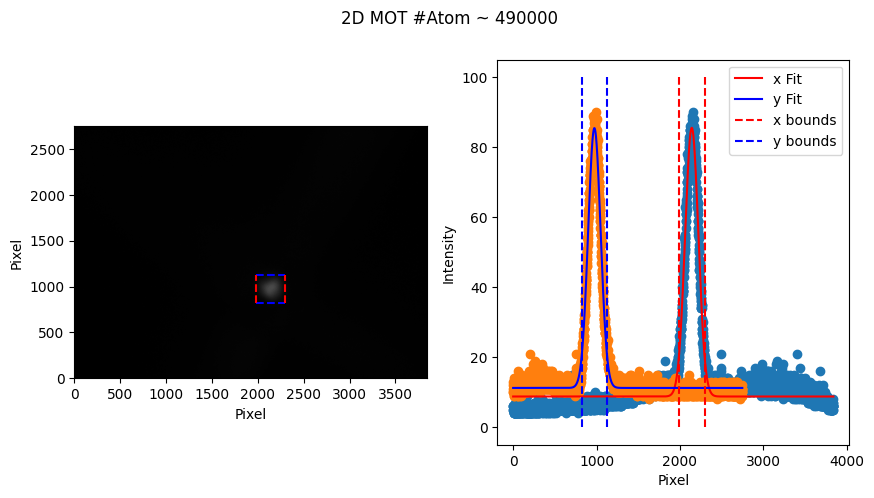

In [4]:
plotMOTNumber(imageio.imread('data/sample_image/sample_2DMOT/signal.bmp'), imageio.imread('data/sample_image/sample_2DMOT/background.bmp'), 17150e-6, 2 * np.pi * 751.5270397e12, 80e-3)